In [2]:
import numpy as np
import string
import re
from collections import Counter
import re
from utils import load_file, postprocess_answer_option_conditioned, parse_path
import numpy as np

## Metrics

In [3]:



def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""

    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def handle_punc(text):
        exclude = set(string.punctuation + "".join([u"‘", u"’", u"´", u"`"]))
        return ''.join(ch if ch not in exclude else ' ' for ch in text)

    def lower(text):
        return text.lower()

    def replace_underscore(text):
        return text.replace('_', ' ')

    return white_space_fix(remove_articles(handle_punc(lower(replace_underscore(s))))).strip()


def f1_score(prediction, ground_truth):
    '''
    pred: str
    gt: str
    '''
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


def exact_match_score(prediction, ground_truth):
    '''
    pred: str
    gt: str
    '''
    return normalize_answer(prediction) == normalize_answer(ground_truth)


def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    '''
    metric_fn: fns that take two strs only
    pred: str
    gts: list(str)
    '''
    if type(ground_truths) == str:
        ground_truths = [ground_truths]
    scores_for_ground_truths = []
    for ground_truth in ground_truths:
        score = metric_fn(prediction, ground_truth)
        scores_for_ground_truths.append(score)
    return max(scores_for_ground_truths)


# def accuracy(preds, labels):
#     match_count = 0
#     for pred, label in zip(preds, labels):
#         target = label[0]
#         if pred == target:
#             match_count += 1

#     return 100 * (match_count / len(preds))

# def accuracy(pred, label):
#     '''
#     akari claimed acc
#     ===
#     pred: str
#     label: str or list(str)
#     '''
#     if type(label) == list:
#         assert len(label) == 1
#         label = label[0]

#     return pred.lower()==label.lower()

def loose_acc(pred, label):
    '''
    pred: str
    label: str
    '''
    # cnt = 0
    pred = normalize_answer(pred)
    label = normalize_answer(label)
    if pred == label:
        return 1
    if len(pred) < len(label):
        return 0
    # if pred.startswith(label):
    #     cnt += len(label)

    # return cnt / len(pred)
    if len(pred.split())>0 and pred.split()[0] == label:
        return 1

    return 0

def loose_match(prediction, ground_truth):
    '''
    pred: str
    gt: str
    '''
    if ground_truth in prediction:
        return 1
    return 0

## Utils

In [4]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Any, Tuple, Literal



In [5]:
def try_load_or_save_ret_p(json_path: str, ret_p: None):
    if 'pqa' in json_path:
        file_name = 'pqa.json'
    elif 'tqa' in json_path:
        file_name = 'tqa.json'
    elif 'arc' in json_path:
        file_name = 'arc.json'
    else:
        file_name = 'health.json'
        
    if ret_p is not None:
        with open(file_name, 'w') as f:
            json.dump(ret_p, f)
    else:
        with open(file_name, 'r') as f:
            ret_p = json.load(f)
    return ret_p

## Scores

In [6]:
def compute_confidence(log_probs:List):
    '''
    log_probs: List[float]
    '''
    return np.mean(np.exp(log_probs))

def compute_inv_perplexity(log_probs:List):
    '''
    log_probs: List[float]
    '''
    return np.exp(np.mean(log_probs))

In [7]:
def false_invperplexity(ret_ind):
    return np.sum(ret_ind['id_log_probs']) / max(1, len(ret_ind['token_ids']))

def true_invperplexity(ret_ind):
    return np.sum(ret_ind['id_log_probs']) / max(1, len(ret_ind['id_log_probs']))

def recompute_score_inv_perplexity(ret_res, is_selfrag):
    """pass res['retrieval_res']"""
    
    res = ret_res.copy()
    ret_prefix = ['retrieval_0', 'retrieval_1', 'retrieval_2', 'retrieval_3', 'retrieval_4']
    for prefix in ret_prefix:
        if is_selfrag:
            score = ret_res[prefix]['score'] - false_invperplexity(ret_res[prefix]) + true_invperplexity(ret_res[prefix])
        else:
            assert false_invperplexity(ret_res[prefix]) - ret_res[prefix]['score'] < 1e-5
            score = true_invperplexity(ret_res[prefix])
        res[prefix]['score'] = score
    return res
        

In [9]:
def recompute_score(ret_res, recompute_fn, is_closed, is_selfrag):
    ret_res = ret_res.copy()
    for i in ret_res:
        i['retrieval_res'] = recompute_fn(i['retrieval_res'],is_selfrag)
        if is_closed:
            answer2score = {}
            for key, result in i['retrieval_res'].items():
                answer = postprocess_answer_option_conditioned(result["pred"])
                if len(answer.split()) > 0:
                    answer = answer.split()[0]
                score = result["score"]
                answer2score.setdefault(answer, 0)
                answer2score[answer] += score
            sorted_answers = sorted(
                answer2score.items(), key=lambda x: x[1], reverse=True)
            best_option = sorted_answers[0][0]
            hit_results = {key: item for key, item in i['retrieval_res'].items() if postprocess_answer_option_conditioned(item["pred"]).startswith(best_option)}
            
            path2score = {key: item["score"] for key,
                            item in hit_results.items()}
            best_path = sorted(path2score.items(),
                                key=lambda x: x[1], reverse=True)[0][0]
            i["best_one"] = i['retrieval_res'][best_path]
            best_option = i['retrieval_res'][best_path]["pred"]
            token_ids = i['retrieval_res'][best_path]["token_ids"]
            id_log_probs = i['retrieval_res'][best_path]["id_log_probs"]
        else:
            path2score = {key: item["score"] for key,
                            item in i['retrieval_res'].items()}
            best_path = sorted(path2score.items(),
                                key=lambda x: x[1], reverse=True)[0][0]
            best_option = i['retrieval_res'][best_path]["pred"]
            token_ids = i['retrieval_res'][best_path]["token_ids"]
            id_log_probs =i['retrieval_res'][best_path]["id_log_probs"]
            i["best_one"] = i['retrieval_res'][best_path]
        
        i["retrieval"] = best_option
        i["retrieval_token_ids"] = token_ids
        i["retrieval_log_probs"] = id_log_probs
    return ret_res
        

## Indicator

In [4]:
def process_res(res_ls:list):
    
    '''
    dict_keys(['no_retrieval', 'no_retrieval_ids', 'no_retrieval_log_probs', 'all_doc_retrieval', 'all_doc_retrieval_ids', 'all_doc_retrieval_log_probs', 'retrieval', 'retrieval_token_ids', 'retrieval_log_probs', 'retrieval_res', 'question_id', 'gold', 'question', 'ret_0', 'ret_0_log_probs', 'ret_0_ctx', 'ret_0_ctx_score', 'ret_0_scores', 'ret_1', 'ret_1_log_probs', 'ret_1_ctx', 'ret_1_ctx_score', 'ret_1_scores', 'ret_2', 'ret_2_log_probs', 'ret_2_ctx', 'ret_2_ctx_score', 'ret_2_scores', 'ret_3', 'ret_3_log_probs', 'ret_3_ctx', 'ret_3_ctx_score', 'ret_3_scores', 'ret_4', 'ret_4_log_probs', 'ret_4_ctx', 'ret_4_ctx_score', 'ret_4_scores', 'all_doc_retrieval_ctx', 'all_doc_retrieval_ctx_score', 'all_doc_retrieval_scores', 'no_retrieval_scores'])
    {}_scores dict_keys(['qa', 'qc', 'ca', 'ret_score'])
    '''
    output = []
    prefix = ['ret_0', 'ret_1', 'ret_2', 'ret_3', 'ret_4', 'all_doc_retrieval', 'no_retrieval', 'retrieval']
    for i, item in enumerate(res_ls):
        max_score = -1
        top_res = None
        for p in prefix:
            if p == "retrieval":
                top_res["ret_name"] = "retrieval"
                output.append(top_res)
                continue
            qa_score = item[p+'_scores']['qa']
            qc_score = item[p+'_scores']['qc']
            ca_score = item[p+'_scores']['ca']
            if p+'_ctx_score' in item:
                assert item[p+'_ctx_score'] == item[p+'_scores']['ret_score']
                ctx_score = float(item[p+'_ctx_score'])
            else:
                ctx_score = float(item[p+'_scores']['ret_score'])
                
            loose_match_ = metric_max_over_ground_truths(loose_match, item[p], item['gold'])
            f1_score_ = metric_max_over_ground_truths(f1_score, item[p], item['gold'])
            em_ = metric_max_over_ground_truths(exact_match_score, item[p], item['gold'])
            loose_acc_ = metric_max_over_ground_truths(loose_acc, item[p], item['gold'])
            dc = {"pred": item[p], "qa_score": qa_score, "qc_score": qc_score, "ca_score": ca_score, "ctx_score": ctx_score, "question_id": item['question_id'], "gold": item['gold'], "question": item['question'], "log_probs": item[p+'_log_probs'], 'confidence': compute_confidence(item[p+'_log_probs']), 'inv_perplexity': compute_inv_perplexity(item[p+'_log_probs']), 'ret_name': p, 'loose_match': loose_match_, 'f1_score': f1_score_, 'em': em_, 'loose_acc': loose_acc_}
            if p in ["ret_0", "ret_1", "ret_2", "ret_3", "ret_4"]:
                if dc['inv_perplexity'] > max_score:
                    max_score = dc['inv_perplexity']
                    top_res = dc.copy()
            output.append(dc)
    
    dc = {"pred": [], "qa_score": [], "qc_score": [], "ca_score": [], "ctx_score": [], "question_id": [], "gold": [], "question": [], "log_probs": [], 'confidence': [], 'inv_perplexity': [], 'ret_name': [], 'loose_match': [], 'f1_score': [], 'em': [], 'loose_acc': []}
    for i, item in enumerate(output):
        for k in dc.keys():
            dc[k].append(item[k])
    return dc

In [5]:
path = 'post_processed\llama2chat-pqa_processed_2mil7.json'
with open(path) as f:
    json_file = json.load(f)
res = process_res(json_file)

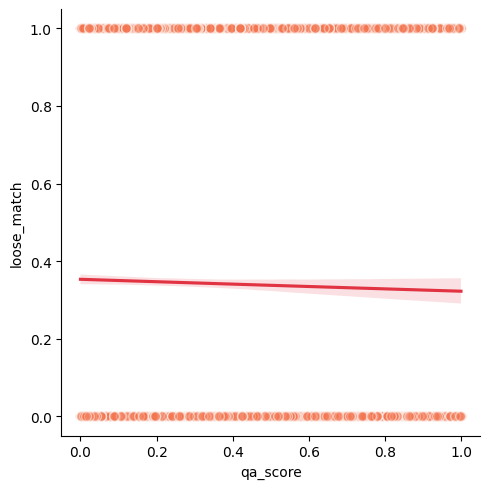

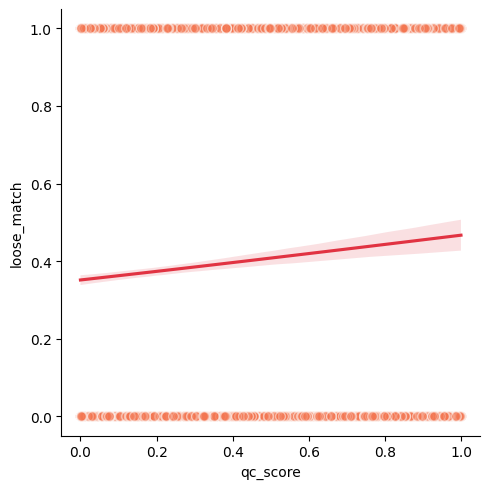

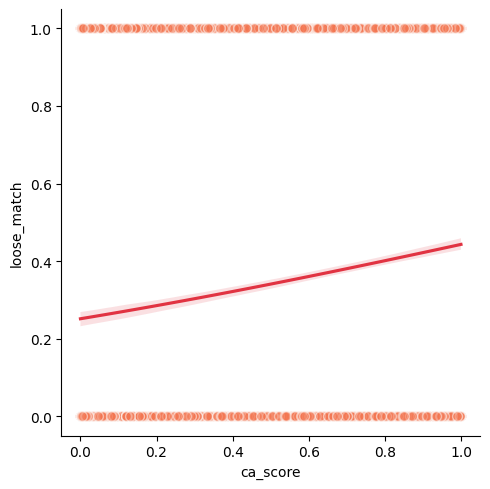

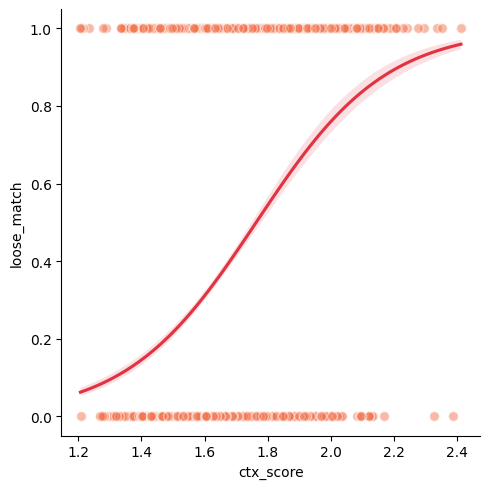

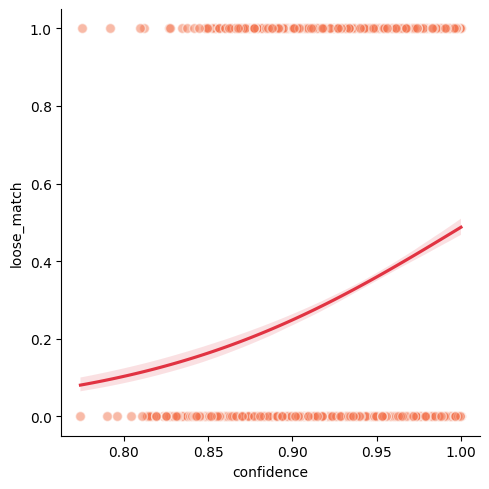

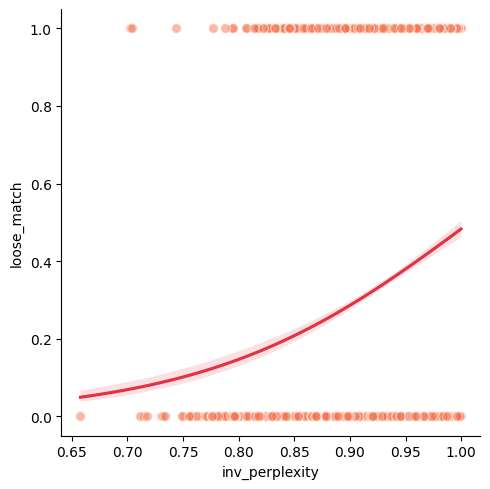

In [7]:



scores = ['qa_score', 'qc_score', 'ca_score', 'ctx_score', 'confidence', 'inv_perplexity']
metric = 'loose_match'

for score in scores:
    df = pd.DataFrame(res)
    df = df[df['ret_name'] != 'retrieval']
    if score == 'ctx_score':
        df = df[(df['ret_name'] != 'no_retrieval') & (df['ret_name'] != 'all_doc_retrieval')]
    elif score in ['qc_score', 'ca_score']:
        df = df[df['ret_name'] != 'no_retrieval']
        
    sns.lmplot(data=df, x=score, y=metric, logistic=True, palette="Set1", scatter_kws={"s": 50, "edgecolor":"w","alpha":.5, 'color': sns.color_palette("rocket")[4]}, line_kws={'color': sns.color_palette("rocket")[3]})

## Res Analysis

In [10]:
import os

In [31]:
class Analyzer:
    def __init__(self, json_path, ret_p=None, threshold=0.5, recompute_fn=recompute_score_inv_perplexity, evaluation_metrics=['loose_match', 'em', 'f1', 'loose_acc']):
        path_ls = json_path.split(os.path.sep)
        file_name = path_ls[-1]
        file_name_ls = file_name.split('-')
        self.model_name = file_name_ls[0]
        self.dataset_name = file_name_ls[1]
        
        
        
        self.df, self.df_dict, self.dc = self.json2df(json_path, ret_p, recompute_fn)
        self.json_path = json_path
        self.threshold = threshold
        model_name, dataset_name, task, args = parse_path(json_path)
        print('#'*20)
        print(f"#Model: {model_name}")
        print(f"#Dataset: {dataset_name}")
        print(f"#Task: {task}")
        print(f"#Args: {args}")
        # self.metric_evaluation(evaluation_metrics)
        

    def json2df(self, json_path, ret_p=None, recompute_fn=None):
        with open(json_path) as f:
            json_file = json.load(f)
            
            if type(json_file) == list:
                # print(json_file[0].keys())
                # print(json_file[0]['ret_0_scores'].keys())
                res = json_file
            else:
                # print(json_file["results"][0].keys())
                # print(json_file["results"][0]["retrieval_res"].keys())
                res = json_file['results']
        if recompute_fn is not None:
            is_closed = 'arc' in json_path or 'health' in json_path
            res = recompute_score(res, recompute_fn, is_closed=is_closed, is_selfrag='self'in json_path)
        no_ret = {"no_ret": [i["no_retrieval"] for i in res]}
        use_all = {"use_all": [i["all_doc_retrieval"] for i in res]}
        select_top = {"select_top": [i['retrieval'] for i in res]}
        retrieval_p = ret_p
        
        
        if 'no_retrieval_log_probs' in json_file['results'][0]:
            logprobs_no_ret = {"logprobs_no_ret": [i["no_retrieval_log_probs"] for i in res]}
            logprobs_use_all = {"logprobs_use_all": [i["all_doc_retrieval_log_probs"] for i in res]}
            logprobs_select_top = {"logprobs_select_top": [i['retrieval_log_probs'] for i in res]}

            avg_confidence_no_ret = {"avg_confidence_no_ret": [np.mean(np.exp(i["no_retrieval_log_probs"])) for i in res]}
            avg_confidence_use_all = {"avg_confidence_use_all": [np.mean(np.exp(i["all_doc_retrieval_log_probs"])) for i in res]}
            avg_confidence_select_top = {"avg_confidence_select_top": [np.mean(np.exp(i['retrieval_log_probs'])) for i in res]}

            inv_perplexity_no_ret = {"inv_perplexity_no_ret": [np.exp(np.mean(i["no_retrieval_log_probs"])) for i in res]}
            inv_perplexity_use_all = {"inv_perplexity_use_all": [np.exp(np.mean(i["all_doc_retrieval_log_probs"])) for i in res]}
            inv_perplexity_select_top = {"inv_perplexity_select_top": [np.exp(np.mean(i['retrieval_log_probs'])) for i in res]}

        
        # else:
        #     logprobs_no_ret = {}
        #     logprobs_use_all = {}
        #     logprobs_select_top = {}

        #     avg_confidence_no_ret = {}
        #     avg_confidence_use_all = {}
        #     avg_confidence_select_top = {}
        
        #     inv_perplexity_no_ret = {}
        #     inv_perplexity_use_all = {}
        #     inv_perplexity_select_top = {}
        
        gold = {"gold": [i['gold'] for i in res]}

        loose_match_no_ret = {"loose_match_no_ret": [metric_max_over_ground_truths(loose_match, i["no_retrieval"], i['gold']) for i in res]}
        loose_match_use_all = {"loose_match_use_all": [metric_max_over_ground_truths(loose_match, i["all_doc_retrieval"], i['gold']) for i in res]}
        loose_match_select_top = {"loose_match_select_top": [metric_max_over_ground_truths(loose_match, i['retrieval'], i['gold']) for i in res]}

        em_no_ret = {"em_no_ret": [metric_max_over_ground_truths(exact_match_score, i["no_retrieval"], i['gold']) for i in res]}
        em_use_all = {"em_use_all": [metric_max_over_ground_truths(exact_match_score, i["all_doc_retrieval"], i['gold']) for i in res]}
        em_select_top = {"em_select_top": [metric_max_over_ground_truths(exact_match_score, i['retrieval'], i['gold']) for i in res]}

        f1_no_ret = {"f1_no_ret": [metric_max_over_ground_truths(f1_score, i["no_retrieval"], i['gold']) for i in res]}
        f1_use_all = {"f1_use_all": [metric_max_over_ground_truths(f1_score, i["all_doc_retrieval"], i['gold']) for i in res]}
        f1_select_top = {"f1_select_top": [metric_max_over_ground_truths(f1_score, i['retrieval'], i['gold']) for i in res]}


        loose_acc_no_ret = {"loose_acc_no_ret": [metric_max_over_ground_truths(loose_acc, i["no_retrieval"], i['gold']) for i in res]}
        loose_acc_use_all = {"loose_acc_use_all": [metric_max_over_ground_truths(loose_acc, i["all_doc_retrieval"], i['gold']) for i in res]}
        loose_acc_select_top = {"loose_acc_select_top": [metric_max_over_ground_truths(loose_acc, i['retrieval'], i['gold']) for i in res]}


        df_dict = {**no_ret, **use_all, **select_top, **logprobs_no_ret, **logprobs_use_all, \
            **logprobs_select_top, **avg_confidence_no_ret, **avg_confidence_use_all, \
            **avg_confidence_select_top, **inv_perplexity_no_ret, **inv_perplexity_use_all, \
            **inv_perplexity_select_top, **retrieval_p, **gold, **loose_match_no_ret, **loose_match_use_all, **loose_match_select_top, **em_no_ret, **em_use_all, **em_select_top, **f1_no_ret, **f1_use_all, **f1_select_top, **loose_acc_no_ret, **loose_acc_use_all, **loose_acc_select_top}
        df = pd.DataFrame(df_dict)
        return df, df_dict, res
    
    def which_doc_is_best(self, metric):
        temp = {'RAG score':[], f'{metric}':[]}
        temp2 = {'RAG result with which doc is best':[]}
        if metric == 'loose_match':
            metric_fn = loose_match
        elif metric == 'loose_acc':
            metric_fn = loose_acc
        for i in self.dc:
            top_acc = -1
            for key in ['retrieval_0', 'retrieval_1', 'retrieval_2', 'retrieval_3', 'retrieval_4']:
                ans = i['retrieval_res'][key]['pred']
                score = i['retrieval_res'][key]['score']
                acc = metric_max_over_ground_truths(metric_fn, ans, i['gold'])
                temp['RAG score'].append(score)
                temp[metric].append(acc)
                if acc > top_acc:
                    best_doc = key
                    top_acc = acc
            temp2['RAG result with which doc is best'].append(best_doc)
        sns.relplot(data=pd.DataFrame(temp), x='RAG score', y=metric, kind="line")
        plt.show()
        sns.histplot(data=pd.DataFrame(temp2), x='RAG result with which doc is best')
        plt.show()
            
    
    
    def metric_evaluation(self, metrics = ['loose_match', 'em', 'f1', 'loose_acc'], retrieval_methods = ['no_ret', 'use_all', 'select_top']):
        '''
        metric: str
        retrieval_method: str
        threshold: float
        '''
        threshold = self.threshold
        
        print(f"Total number of samples: {len(self.df)}")
        print(f"Retrieval threshold: {threshold}")
        print(f"Number of samples with retrieval probability > {threshold}: {len(self.df[self.df['retrieval_p'] > threshold])}")
        print(f"Number of samples with retrieval probability <= {threshold}: {len(self.df[self.df['retrieval_p'] <= threshold])}")
        print(f"Retrieval frequency: {len(self.df[self.df['retrieval_p'] > threshold])/len(self.df)}")
        for method in retrieval_methods:
            print(f"====== {method} ======")
            
            if method == 'no_ret':
                for metric in metrics:
                    print(f"{metric}: {self.df[f'{metric}_{method}'].mean()}")
                    print()
            else:
                print()
                for metric in metrics:
                    print(f"{metric}_all_ret: {self.df[f'{metric}_{method}'].mean()}")
                    if len(self.df[self.df['retrieval_p'] > threshold]) == len(self.df):
                        print('Adaptive retrieval DEGRADES to all retrieval because retrieval probability is always greater than threshold')
                    else:
                        print(f"{metric}_adp_ret: {(self.df[self.df['retrieval_p'] > threshold][f'{metric}_{method}'].sum() + self.df[self.df['retrieval_p'] <= threshold][f'{metric}_no_ret'].sum())/len(self.df)}")
                    print()
    
    def select_by_confidence(self):
        golds = self.df['gold']
        ans = []
        for row_dict in self.df.to_dict(orient="records"):
            if row_dict['retrieval_p'] > 0.5:
                ans.append(row_dict['use_all'])
            elif row_dict['avg_confidence_no_ret'] > row_dict['avg_confidence_use_all']:
                ans.append(row_dict['no_ret'])
            else:
                ans.append(row_dict['use_all'])
        print('match', np.mean([metric_max_over_ground_truths(loose_match, i, j) for i, j in zip(ans, golds)]))
        print('acc', np.mean([metric_max_over_ground_truths(loose_acc, i, j) for i, j in zip(ans, golds)]))
        
        
    def retrieve_p_distribution(self):
        return sns.displot(self.df['retrieval_p'], kde=True, stat="density").set(xticks=[i/10 for i in range(0,11)]).set(title=f"{self.model_name} on {self.dataset_name}: Retrieval probability distribution")
    
    
    def compare_retrieval_methods_by_metrics(self):
        METRICS = ['loose_match', 'em', 'f1', 'loose_acc']
        METHODS = ['no_ret', 'use_all', 'select_top']
        
        dc_metrics = {"metric":[], "mean":[], "retrieval method":[]}

        for row_dict in self.df.to_dict(orient="records"):

            for method in METHODS:
                for metric in METRICS:
                    dc_metrics["mean"].append(row_dict[f"{metric}_{method}"])
                    dc_metrics["metric"].append(metric)
                    dc_metrics["retrieval method"].append(method)
        return sns.catplot(data=pd.DataFrame(dc_metrics), x="retrieval method", y="mean", hue="metric", kind="point")     
        
    def metrics_varying_threshold(self, interval=0.01, ret_method:Literal['no_ret', 'use_all', 'select_top']='select_top'):
        '''
        metric: str
        threshold: str
        '''
        METRICS = ['loose_match', 'em', 'f1', 'loose_acc']

        df_thres = {"retrieval threshold":[], "metrics":[], "mean":[]}
        for thres in [interval*i for i in range(0, int(1/interval)+1)]:
            
            for metric in METRICS:
                df_thres["retrieval threshold"].append(thres)
                metric_mean = self.df[self.df['retrieval_p'] > thres][f'{metric}_{ret_method}'].sum() + self.df[self.df['retrieval_p'] <= thres][f'{metric}_no_ret'].sum()
                metric_mean /= len(self.df)
                df_thres["metrics"].append(metric)
                df_thres["mean"].append(metric_mean)
            df_thres["metrics"].append("retrieval frequency")
            df_thres["mean"].append(len(self.df[self.df['retrieval_p'] > thres])/len(self.df))
            df_thres["retrieval threshold"].append(thres)
        return sns.relplot(
                    data=pd.DataFrame(df_thres), kind="line",
                    x="retrieval threshold", y="mean", hue="metrics",
                    sort=False
                ).set(title=f"Metrics varying threshold by retrieval method: {ret_method}")
    
    
    
    def metrics_varying_threshold_by_retrieval_method(self, interval=0.01):
        METRICS = ['loose_match', 'em', 'f1', 'loose_acc']


        df_thres = {"retrieval threshold":[], "metrics":[], "mean":[], "retrieval method":[]}
        for method in ['use_all', 'select_top']:
            for thres in [interval*i for i in range(0, int(1/interval)+1)]:

                for metric in METRICS:
                    df_thres["retrieval threshold"].append(thres)
                    metric_mean = self.df[self.df['retrieval_p'] > thres][f'{metric}_{method}'].sum() + self.df[self.df['retrieval_p'] <= thres][f'{metric}_no_ret'].sum()
                    metric_mean /= len(self.df)
                    df_thres["metrics"].append(metric)
                    df_thres["mean"].append(metric_mean)
                    df_thres["retrieval method"].append(method)
                df_thres["metrics"].append("retrieval frequency")
                df_thres["mean"].append(len(self.df[self.df['retrieval_p'] > thres])/len(self.df))
                df_thres["retrieval threshold"].append(thres)
                df_thres["retrieval method"].append(method)
        g = sns.FacetGrid(pd.DataFrame(df_thres), col="retrieval method", hue="metrics")
        g.map(sns.lineplot, "retrieval threshold", "mean").add_legend()
        return g
    
    
    def best_method_for_metric(self, metric:Literal['loose_match', 'em', 'f1', 'loose_acc']):
        dc_best = {f"best retrieval method, metric={metric}":[]}
        for row_dict in self.df.to_dict(orient="records"):
            if row_dict[f"{metric}_no_ret"] > row_dict[f"{metric}_use_all"] and row_dict[f"{metric}_no_ret"] > row_dict[f"{metric}_select_top"]:
                best_method = "no_ret"
            elif row_dict[f"{metric}_select_top"] == row_dict[f"{metric}_use_all"] and row_dict[f"{metric}_select_top"] == row_dict[f"{metric}_no_ret"]:
                best_method = "equal"
            elif row_dict[f"{metric}_use_all"] > row_dict[f"{metric}_select_top"] and row_dict[f"{metric}_use_all"] > row_dict[f"{metric}_no_ret"]:
                best_method = "use_all"
            elif row_dict[f"{metric}_select_top"] > row_dict[f"{metric}_use_all"] and row_dict[f"{metric}_select_top"] > row_dict[f"{metric}_no_ret"]:
                best_method = "select_top"
            elif row_dict[f"{metric}_select_top"] == row_dict[f"{metric}_use_all"]:
                best_method = "use_all&select_top"
            elif row_dict[f"{metric}_select_top"] == row_dict[f"{metric}_no_ret"]:
                best_method = "select_top&no_ret"
            elif row_dict[f"{metric}_use_all"] == row_dict[f"{metric}_no_ret"]:
                best_method = "use_all&no_ret"
            else:
                raise ValueError("Unknown best method")
            dc_best[f"best retrieval method, metric={metric}"].append(best_method)
        
        df = pd.DataFrame(dc_best)
        ax = sns.histplot(df, x = f"best retrieval method, metric={metric}")
        for i in ax.containers:
            ax.bar_label(i,)
            
        ax.set_title(f'Best retrieval method for metric: {metric}')
        return ax
    
    def best_method_for_metric1(self, metric:Literal['loose_match', 'em', 'f1', 'loose_acc'], indicator:Literal['avg_confidence', 'inv_perplexity']):
        
        METHODS = ['no_ret', 'use_all', 'select_top']
        dc_best = {f"best retrieval method, metric={metric}":[], "retreival method":[], indicator:[]}
        for row_dict in self.df.to_dict(orient="records"):
            if row_dict[f"{metric}_no_ret"] > row_dict[f"{metric}_use_all"] and row_dict[f"{metric}_no_ret"] > row_dict[f"{metric}_select_top"]:
                best_method = "no_ret"
            elif row_dict[f"{metric}_select_top"] == row_dict[f"{metric}_use_all"] and row_dict[f"{metric}_select_top"] == row_dict[f"{metric}_no_ret"]:
                best_method = "equal"
            elif row_dict[f"{metric}_use_all"] > row_dict[f"{metric}_select_top"] and row_dict[f"{metric}_use_all"] > row_dict[f"{metric}_no_ret"]:
                best_method = "use_all"
            elif row_dict[f"{metric}_select_top"] > row_dict[f"{metric}_use_all"] and row_dict[f"{metric}_select_top"] > row_dict[f"{metric}_no_ret"]:
                best_method = "select_top"
            elif row_dict[f"{metric}_select_top"] == row_dict[f"{metric}_use_all"]:
                best_method = "use_all&select_top"
            elif row_dict[f"{metric}_select_top"] == row_dict[f"{metric}_no_ret"]:
                best_method = "select_top&no_ret"
            elif row_dict[f"{metric}_use_all"] == row_dict[f"{metric}_no_ret"]:
                best_method = "use_all&no_ret"
            else:
                raise ValueError("Unknown best method")
            for method in METHODS:
                dc_best["retreival method"].append(method)
                dc_best[indicator].append(row_dict[f"{indicator}_{method}"])
                dc_best[f"best retrieval method, metric={metric}"].append(best_method)
        
        df = pd.DataFrame(dc_best)
        ax = sns.catplot(data=df, x=f"best retrieval method, metric={metric}", y=indicator, hue="retreival method", kind="box")
        ax.fig.subplots_adjust(top=0.9) 
        ax.fig.suptitle(f'{indicator} distributions grouped by retrieve method for metric: {metric}')
        return ax
    
    def best_method_for_metric2(self, metric:Literal['loose_match', 'em', 'f1', 'loose_acc'], indicator:Literal['avg_confidence', 'inv_perplexity']):
        
        METHODS = ['no_ret', 'select_top']
        dc_best = {f"best retrieval method by metric={metric}":[], "retreival method":[], indicator:[]}
        for row_dict in self.df.to_dict(orient="records"):
            if row_dict[f"{metric}_no_ret"] > row_dict[f"{metric}_select_top"]:
                best_method = "no_ret"
            elif row_dict[f"{metric}_select_top"] == row_dict[f"{metric}_no_ret"]:
                best_method = "equal"
            elif row_dict[f"{metric}_select_top"] > row_dict[f"{metric}_no_ret"]:
                best_method = "select_top"
            else:
                raise ValueError("Unknown best method")
            for method in METHODS:
                dc_best["retreival method"].append(method)
                dc_best[indicator].append(row_dict[f"{indicator}_{method}"])
                dc_best[f"best retrieval method by metric={metric}"].append(best_method)
        
        df = pd.DataFrame(dc_best)
        ax = sns.catplot(data=df, x=f"best retrieval method by metric={metric}", y=indicator, hue="retreival method", kind="box")
        ax.fig.subplots_adjust(top=0.9) 
        if indicator == 'avg_confidence':
            indicator_name = 'pred confidence'
        else:
            indicator_name = 'pred inverse perplexity'
        ax.fig.suptitle(f'{self.model_name} on {self.dataset_name}: {indicator_name} distributions comparison\nbest method selected by metric: {metric}',fontsize='small')
        
        METHODS = ['no_ret', 'use_all']
        dc_best = {f"best retrieval method by metric={metric}":[], "retreival method":[], indicator:[]}
        for row_dict in self.df.to_dict(orient="records"):
            if row_dict[f"{metric}_no_ret"] > row_dict[f"{metric}_use_all"]:
                best_method = "no_ret"
            elif row_dict[f"{metric}_use_all"] == row_dict[f"{metric}_no_ret"]:
                best_method = "equal"
            elif row_dict[f"{metric}_use_all"] > row_dict[f"{metric}_no_ret"]:
                best_method = "use_all"
            else:
                raise ValueError("Unknown best method")
            for method in METHODS:
                dc_best["retreival method"].append(method)
                dc_best[indicator].append(row_dict[f"{indicator}_{method}"])
                dc_best[f"best retrieval method by metric={metric}"].append(best_method)
        
        df = pd.DataFrame(dc_best)
        ax = sns.catplot(data=df, x=f"best retrieval method by metric={metric}", y=indicator, hue="retreival method", kind="box")
        ax.fig.subplots_adjust(top=0.9) 
        ax.fig.suptitle(f'{self.model_name} on {self.dataset_name}: {indicator_name} distributions comparison\nbest method selected by metric: {metric}',fontsize='small')
    
    def compare_indictor_no_ret(self, metric:Literal['loose_match', 'em', 'f1', 'loose_acc'], indicator:Literal['avg_confidence', 'inv_perplexity']):
        
        METHODS = ['no_ret', 'use_all', 'select_top']
        dc_best = {f"best retrieval method, metric={metric}":[], "retrieval method":[], indicator:[]}
        for row_dict in self.df.to_dict(orient="records"):
            if row_dict[f"{metric}_no_ret"] > row_dict[f"{metric}_use_all"] and row_dict[f"{metric}_no_ret"] > row_dict[f"{metric}_select_top"]:
                best_method = "no_ret"
            elif row_dict[f"{metric}_select_top"] == row_dict[f"{metric}_use_all"] and row_dict[f"{metric}_select_top"] == row_dict[f"{metric}_no_ret"]:
                best_method = "equal"
                continue
            elif row_dict[f"{metric}_use_all"] > row_dict[f"{metric}_select_top"] and row_dict[f"{metric}_use_all"] > row_dict[f"{metric}_no_ret"]:
                best_method = "use_all"
                continue
            elif row_dict[f"{metric}_select_top"] > row_dict[f"{metric}_use_all"] and row_dict[f"{metric}_select_top"] > row_dict[f"{metric}_no_ret"]:
                best_method = "select_top"
                continue
            elif row_dict[f"{metric}_select_top"] == row_dict[f"{metric}_use_all"]:
                best_method = "use_all&select_top"
                continue
            elif row_dict[f"{metric}_select_top"] == row_dict[f"{metric}_no_ret"]:
                best_method = "select_top&no_ret"
            elif row_dict[f"{metric}_use_all"] == row_dict[f"{metric}_no_ret"]:
                best_method = "use_all&no_ret"
            else:
                raise ValueError("Unknown best method")
            for method in METHODS:
                dc_best["retrieval method"].append(method)
                dc_best[indicator].append(row_dict[f"{indicator}_{method}"])
                dc_best[f"best retrieval method, metric={metric}"].append(best_method)

        df = pd.DataFrame(dc_best)
        print(df)
        ax = sns.catplot(data=df, x="retrieval method", y=indicator, hue=f"best retrieval method, metric={metric}", kind="point")
        return ax
    
    
    
    def best_method_for_all_metrics(self):
        METRICS = ['loose_match', 'em', 'f1', 'loose_acc']
        dc_best = {"best retrieval method":[], "metric":[]}
        for metric in METRICS:
            for row_dict in self.df.to_dict(orient="records"):
                if row_dict[f"{metric}_no_ret"] > row_dict[f"{metric}_use_all"] and row_dict[f"{metric}_no_ret"] > row_dict[f"{metric}_select_top"]:
                    best_method = "no_ret"
                elif row_dict[f"{metric}_select_top"] == row_dict[f"{metric}_use_all"] and row_dict[f"{metric}_select_top"] == row_dict[f"{metric}_no_ret"]:
                    best_method = "equal"
                elif row_dict[f"{metric}_use_all"] > row_dict[f"{metric}_select_top"] and row_dict[f"{metric}_use_all"] > row_dict[f"{metric}_no_ret"]:
                    best_method = "use_all"
                elif row_dict[f"{metric}_select_top"] > row_dict[f"{metric}_use_all"] and row_dict[f"{metric}_select_top"] > row_dict[f"{metric}_no_ret"]:
                    best_method = "select_top"
                elif row_dict[f"{metric}_select_top"] == row_dict[f"{metric}_use_all"]:
                    best_method = "use_all&select_top"
                elif row_dict[f"{metric}_select_top"] == row_dict[f"{metric}_no_ret"]:
                    best_method = "select_top&no_ret"
                elif row_dict[f"{metric}_use_all"] == row_dict[f"{metric}_no_ret"]:
                    best_method = "use_all&no_ret"
                else:
                    raise ValueError("Unknown best method")
                dc_best["best retrieval method"].append(best_method)
                dc_best["metric"].append(metric)
        df = pd.DataFrame(dc_best)
        
        g = sns.catplot(data=df, x="best retrieval method", hue="metric", kind="count", legend=True)

        # extract the matplotlib axes_subplot objects from the FacetGrid
        ax = g.facet_axis(0, 0)  # or ax = g.axes.flat[0]

        # iterate through the axes containers
        for c in ax.containers:
            labels = [f'{int(v.get_height())}' for v in c]
            ax.bar_label(c, labels=labels, label_type='edge')
        return ax
    
    def metric_wrt_indictor(self, metric:Literal['loose_match', 'em', 'f1', 'loose_acc'], ret_method:Literal['no_ret', 'use_all', 'select_top']):
        '''
        metric: str
        indicator: str
        '''
        
        indicator = ['avg_confidence']
        
        for ind in indicator:

            ax = sns.lmplot(data=pd.DataFrame({f"{metric}":self.df[f"{metric}_{ret_method}"], f"{ind}": self.df[f"{ind}_{ret_method}"]}), x= f"{ind}", y=f"{metric}", logistic=True, palette="Set1", scatter_kws={"s": 50, "edgecolor":"w","alpha":.5, 'color': sns.color_palette("rocket")[4]}, line_kws={'color': sns.color_palette("rocket")[3]}).set(title =  f'Relationship between {ind} and {metric} metric for retrieval method: {ret_method}')
            ax.figure.set_size_inches(10, 5)
    
    def draw_plots(self, metrics:List = ['loose_match', 'em', 'f1', 'loose_acc'], indicators:List = ['avg_confidence', 'inv_perplexity']):
        
        # sns.set(rc={'axes.facecolor':'#fafafa', 'figure.facecolor':'#fafafa'})
        ax1 = self.retrieve_p_distribution()
        ax2 = self.compare_retrieval_methods_by_metrics()
        ax3 = self.metrics_varying_threshold_by_retrieval_method(interval=0.01)
        plt.show()
        # ax6 = self.best_method_for_all_metrics()
        size_inch = ax3.figure.get_size_inches()
        # ax6.figure.set_size_inches(10, 5)
        # plt.show()
        for metric in metrics:
            # ax4 = self.best_method_for_metric(metric=metric)
            # ax4.figure.set_size_inches(10, 5)
            # plt.show()
            # ax4.figure.set_size_inches(size_inch)

            for indicator in indicators:
                # ax5 = self.best_method_for_metric1(metric=metric, indicator=indicator)
                # ax5.figure.set_size_inches(10, 5)
                # plt.show()
                # ax5.figure.set_size_inches(size_inch)
                ax6 = self.best_method_for_metric2(metric=metric, indicator=indicator)
                plt.show()
        # self.metric_wrt_indictor(metric='f1', ret_method='select_top')
        plt.show()
        
        # ax8 = self.compare_indictor_no_ret(metric = "loose_match", indicator = "avg_confidence")
        
                    
                    


In [27]:
files_dc = {
    r'eval_res\selfrag-pqa-fullspan.json': r'eval_res\selfragadp-pqa.json',
    r'eval_res\selfrag-tqa-fullspan.json': r'eval_res\selfragadp-tqa.json',
    r'eval_res\selfrag-health-fullspan.json': r'eval_res\selfragadp-health.json',
    r'eval_res\selfrag-arc-fullspan.json': r'eval_res\selfragadp-arc.json',
    r'eval_res\llama2chat-pqa-fullspan.json': r'eval_res\llama2chat-pqa-selfadp.json',
    r'eval_res\llama2chat-tqa-fullspan.json': r'eval_res\llama2chat-tqa-selfadp.json',
    r'eval_res\llama2chat-health-fullspan-w_exp.json': r'eval_res\llama2chat-health-selfadp.json',
    r'eval_res\llama2chat-health-fullspan.json': r'eval_res\llama2chat-health-selfadp.json',
    r'eval_res\llama2chat-arc-fullspan-w_exp.json': r'eval_res\llama2chat-arc-selfadp.json',
    r'eval_res\llama2chat-arc-fullspan.json': r'eval_res\llama2chat-arc-selfadp.json',
    r'eval_res\llama3Ins-pqa-fullspan.json': r'eval_res\llama3Ins-pqa-selfadp.json',
    r'eval_res\llama3Ins-tqa-fullspan.json': r'eval_res\llama3Ins-tqa-selfadp.json',
    r'eval_res\llama3Ins-health-fullspan.json': r'eval_res\llama3Ins-health-selfadp.json',
    r'eval_res\llama3Ins-health-fullspan-w_exp.json': r'eval_res\llama3Ins-health-selfadp.json',
    r'eval_res\llama3Ins-arc-fullspan.json': r'eval_res\llama3Ins-arc-selfadp.json',
    r'eval_res\llama3Ins-arc-fullspan-w_exp.json': r'eval_res\llama3Ins-arc-selfadp.json',
    
}

####################
#Model: selfrag
#Dataset: pqa
#Task: pqa
#Args: fullspan


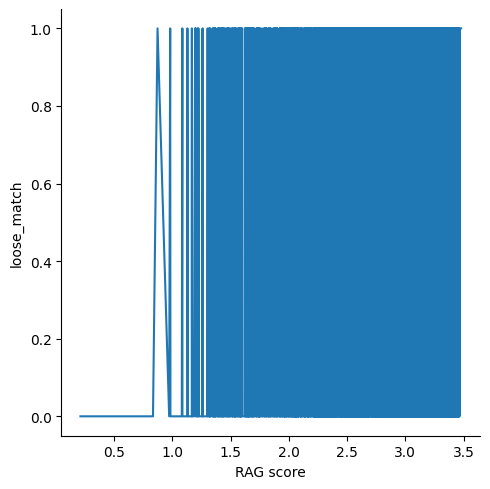

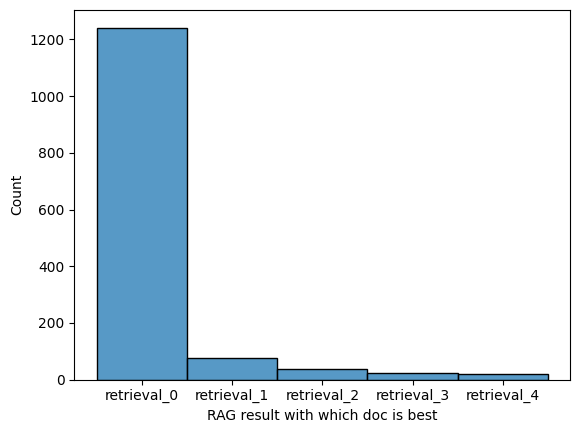

####################
#Model: selfrag
#Dataset: tqa
#Task: tqa
#Args: fullspan


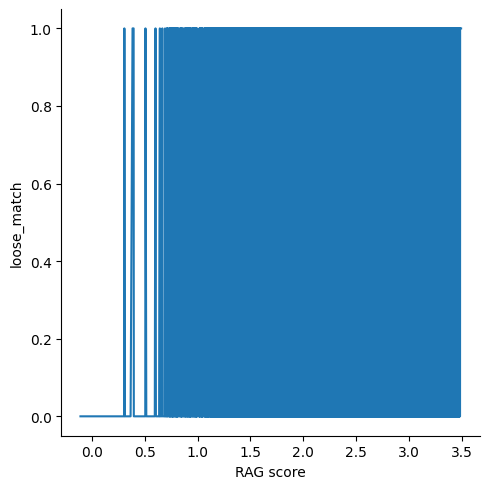

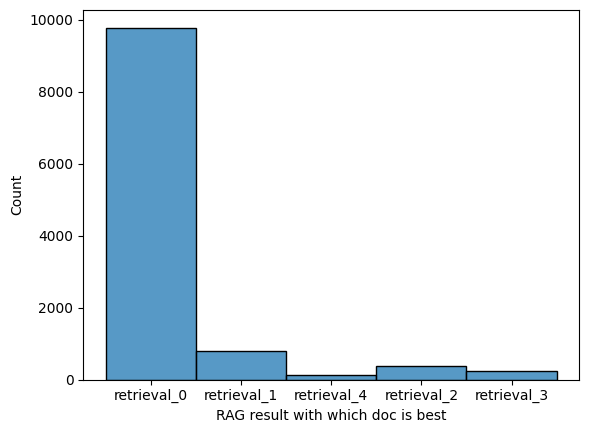

####################
#Model: selfrag
#Dataset: health
#Task: fever
#Args: fullspan


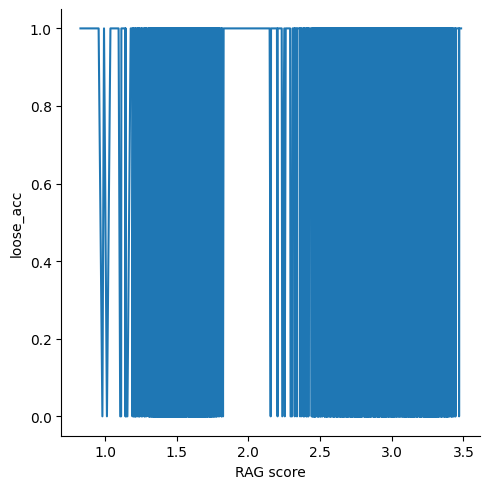

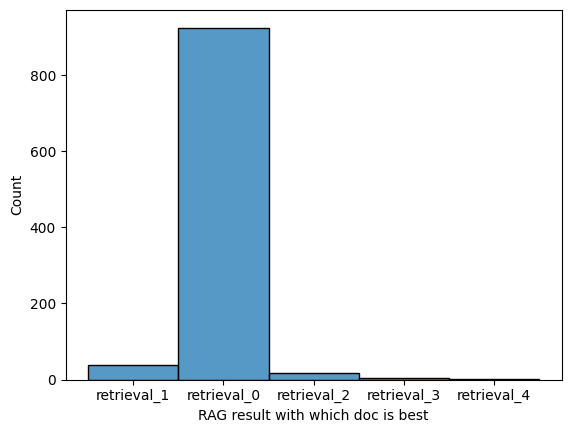

####################
#Model: selfrag
#Dataset: arc
#Task: arc_c
#Args: fullspan


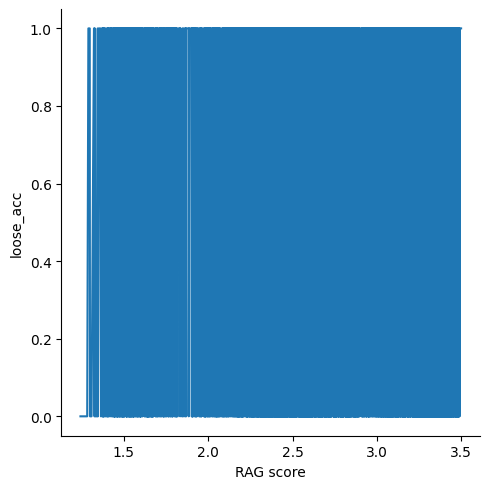

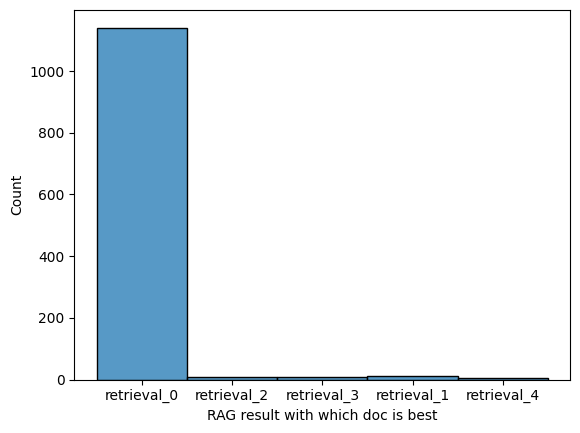

####################
#Model: llama2chat
#Dataset: pqa
#Task: pqa
#Args: fullspan


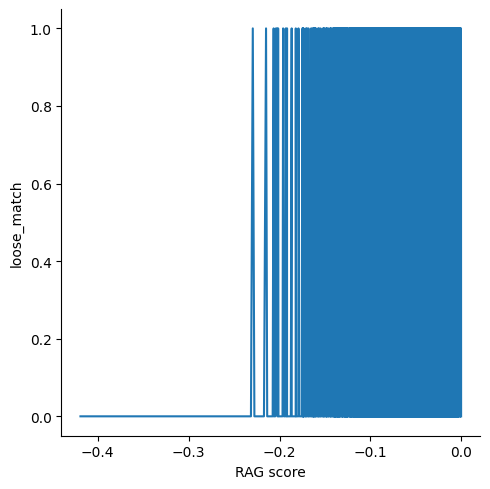

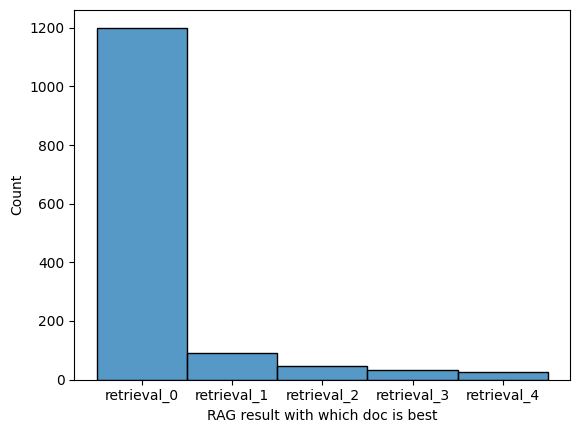

####################
#Model: llama2chat
#Dataset: tqa
#Task: tqa
#Args: fullspan


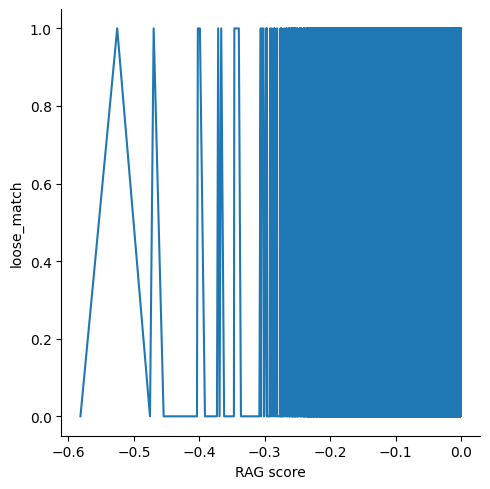

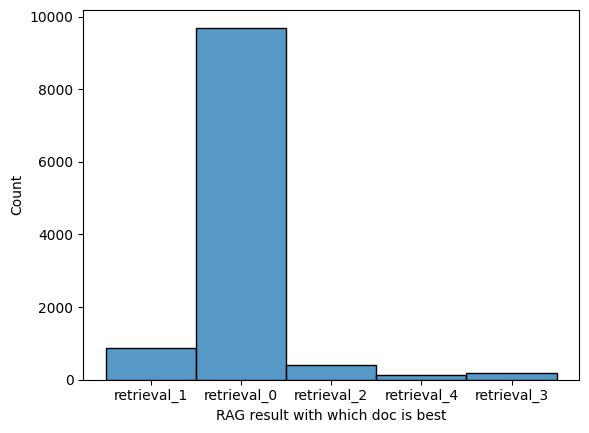

####################
#Model: llama2chat
#Dataset: health
#Task: fever
#Args: fullspan w exp


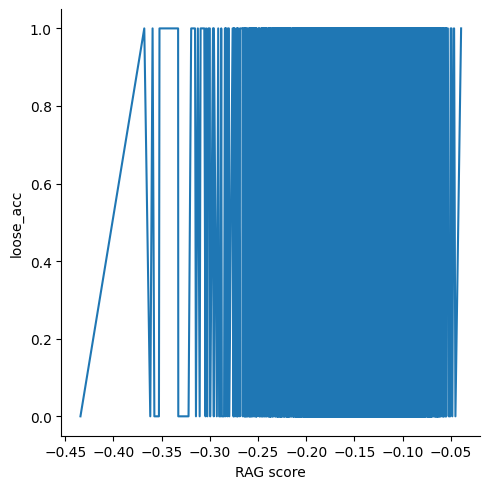

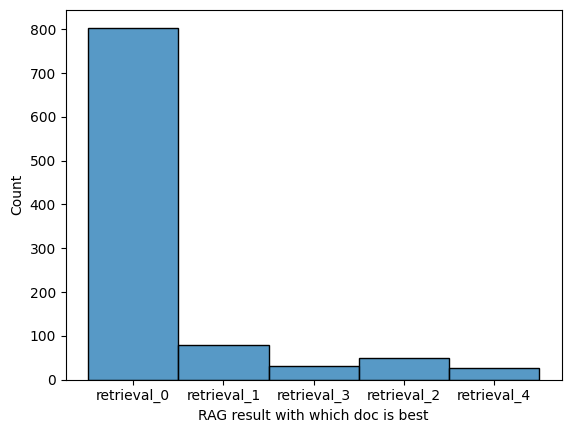

####################
#Model: llama2chat
#Dataset: health
#Task: fever
#Args: fullspan


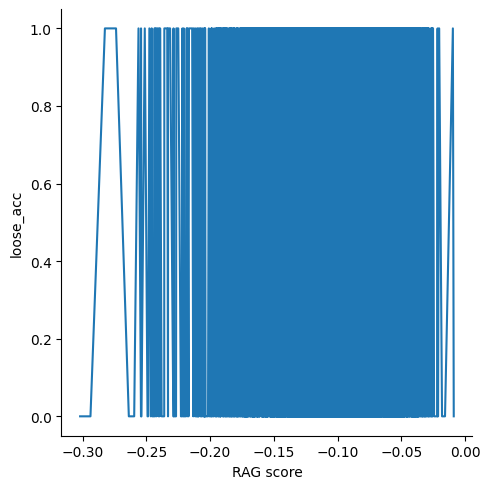

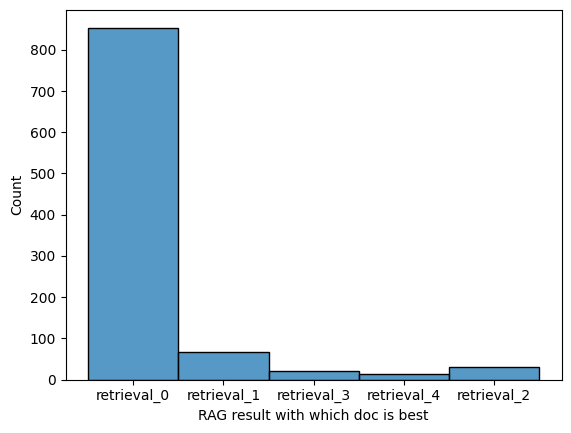

####################
#Model: llama2chat
#Dataset: arc
#Task: arc_c
#Args: fullspan w exp


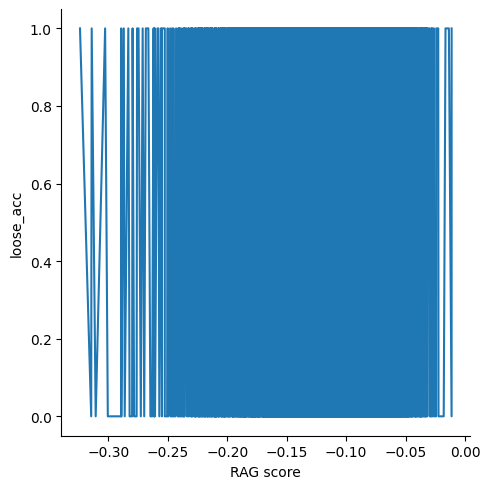

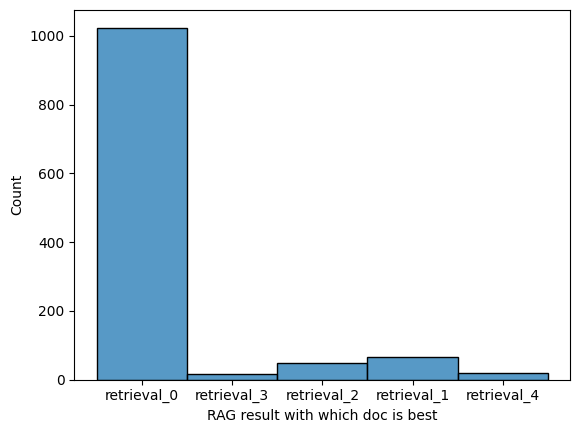

####################
#Model: llama2chat
#Dataset: arc
#Task: arc_c
#Args: fullspan


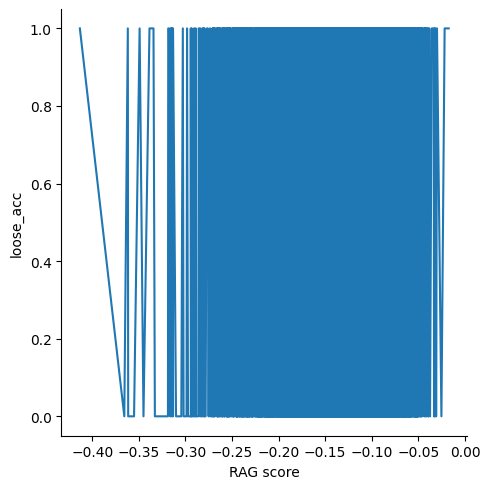

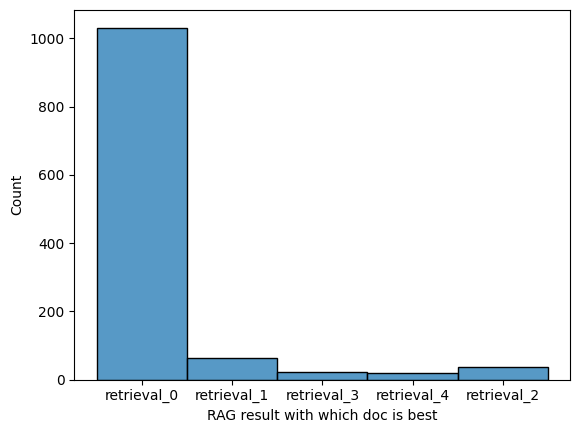

####################
#Model: llama3Ins
#Dataset: pqa
#Task: pqa
#Args: fullspan


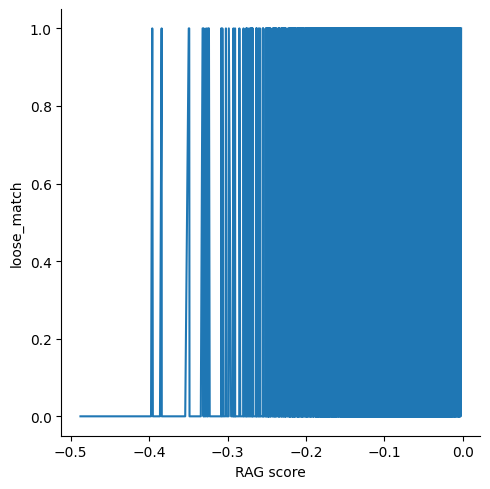

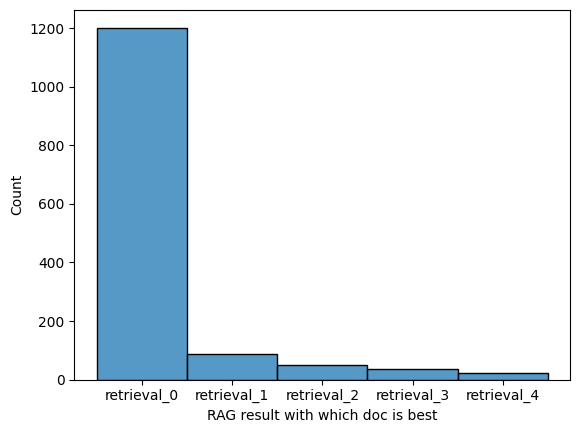

####################
#Model: llama3Ins
#Dataset: tqa
#Task: tqa
#Args: fullspan


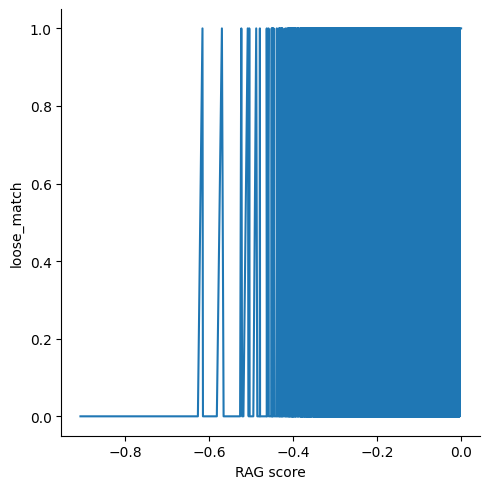

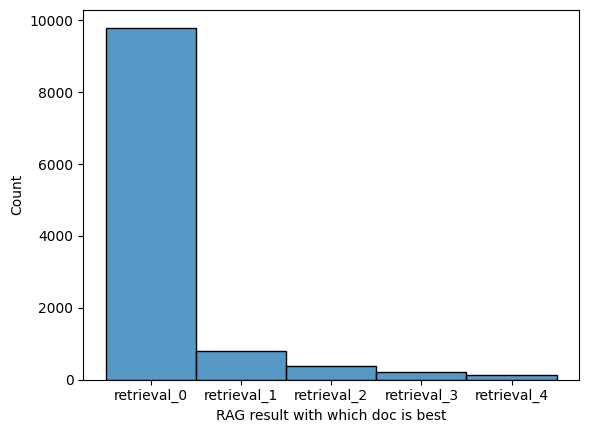

####################
#Model: llama3Ins
#Dataset: health
#Task: fever
#Args: fullspan


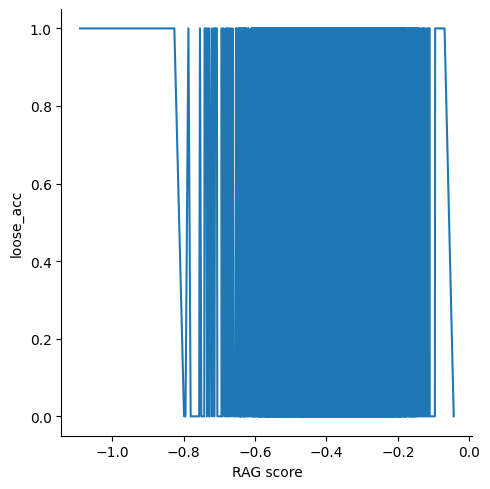

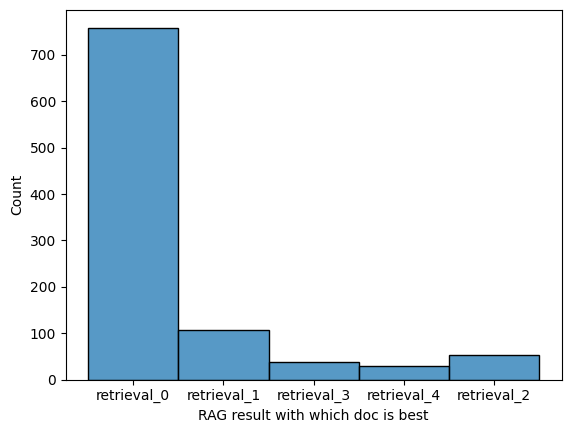

####################
#Model: llama3Ins
#Dataset: health
#Task: fever
#Args: fullspan w exp


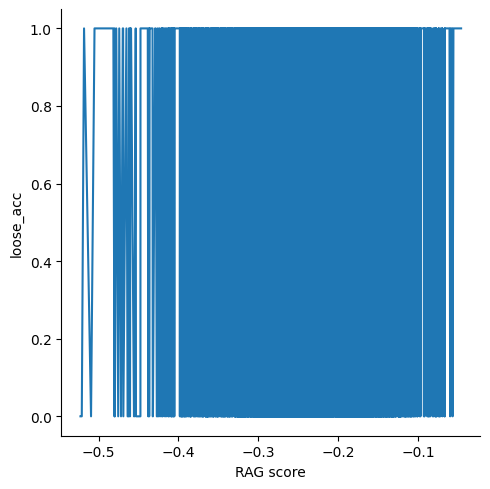

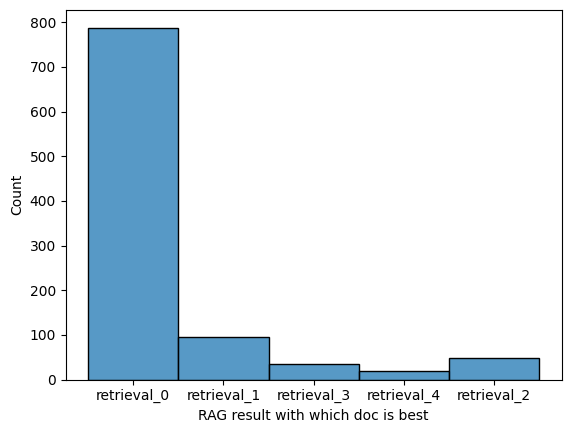

####################
#Model: llama3Ins
#Dataset: arc
#Task: arc_c
#Args: fullspan


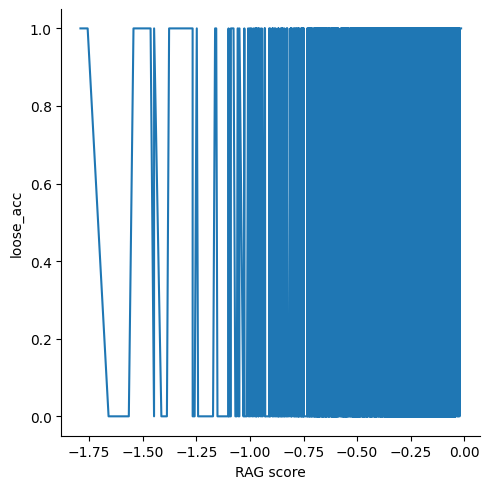

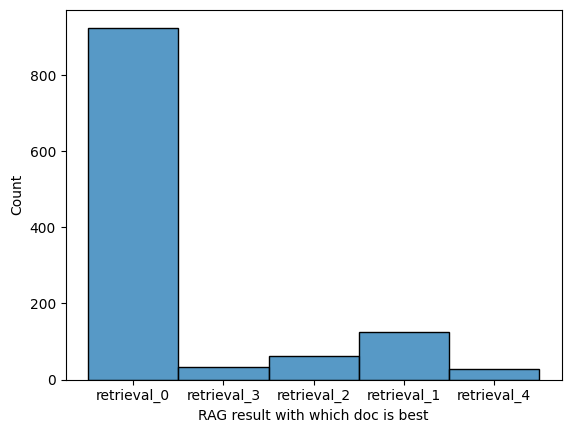

####################
#Model: llama3Ins
#Dataset: arc
#Task: arc_c
#Args: fullspan w exp


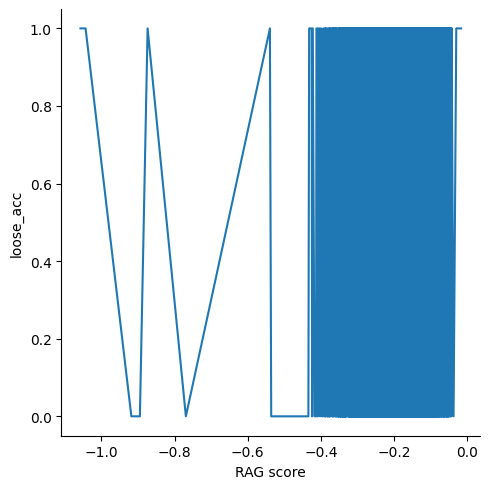

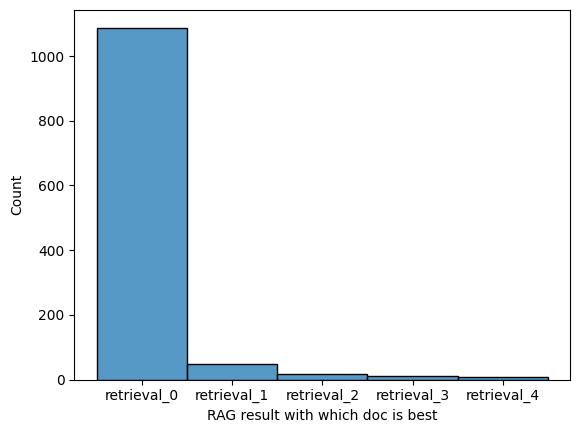

In [32]:
for k, v in files_dc.items():
    ret_p_path = v
    with open(ret_p_path, 'r') as f:
        ret_p_file = json.load(f)
    path = k
    if 'pqa' in path or 'tqa' in path:
        metric="loose_match"
    else:
        metric='loose_acc'
        
    analyzer = Analyzer(path, {"retrieval_p": ret_p_file['retrieval_p']}, threshold=0.2, recompute_fn=recompute_score_inv_perplexity, evaluation_metrics=[metric])
    # analyzer.select_by_confidence()
    analyzer.which_doc_is_best(metric)

In [16]:

for k, v in files_dc.items():
    
    ret_p_path = v
    with open(ret_p_path, 'r') as f:
        ret_p_file = json.load(f)
    path = k
    if 'pqa' in path or 'tqa' in path:
        metric="loose_match"
    else:
        metric='loose_acc'
        
    analyzer = Analyzer(path, {"retrieval_p": ret_p_file['retrieval_p']}, threshold=0.2, recompute_fn=recompute_score_inv_perplexity, evaluation_metrics=[metric])

    # analyzer.draw_plots(metrics = [metric], indicators=["avg_confidence"])

####################
#Model: selfrag
#Dataset: pqa
#Task: pqa
#Args: fullspan
Total number of samples: 1399
Retrieval threshold: 0.2
Number of samples with retrieval probability > 0.2: 1399
Number of samples with retrieval probability <= 0.2: 0
Retrieval frequency: 1.0
====== no_ret ======
loose_match: 0.28377412437455324

====== use_all ======

loose_match_all_ret: 0.4481772694781987
Adaptive retrieval DEGRADES to all retrieval because retrieval probability is always greater than threshold

====== select_top ======

loose_match_all_ret: 0.5218012866333095
Adaptive retrieval DEGRADES to all retrieval because retrieval probability is always greater than threshold

####################
#Model: selfrag
#Dataset: tqa
#Task: tqa
#Args: fullspan
Total number of samples: 11313
Retrieval threshold: 0.2
Number of samples with retrieval probability > 0.2: 11313
Number of samples with retrieval probability <= 0.2: 0
Retrieval frequency: 1.0
====== no_ret ======
loose_match: 0.5042871033324494

==

dict_keys(['no_retrieval', 'no_retrieval_ids', 'no_retrieval_log_probs', 'all_doc_retrieval', 'all_doc_retrieval_ids', 'all_doc_retrieval_log_probs', 'retrieval', 'retrieval_token_ids', 'retrieval_log_probs', 'retrieval_res', 'question_id', 'gold'])
dict_keys(['retrieval_0', 'retrieval_1', 'retrieval_2', 'retrieval_3', 'retrieval_4'])
====== no_ret ======
Total number of samples: 1399

loose_match: 0.2015725518227305

em: 0.0

f1: 0.020929076499902506

loose_acc: 0.0035739814152966403

====== use_all ======
Threshold: 0.2
Total number of samples: 1399
Number of samples with retrieval probability > 0.2: 1399
Number of samples with retrieval probability <= 0.2: 0
Retrieval frequency: 1.0

loose_match_all_ret: 0.557541100786276
loose_match_adp_ret: 0.557541100786276

em_all_ret: 0.0
em_adp_ret: 0.0

f1_all_ret: 0.12853657522848302
f1_adp_ret: 0.12853657522848302

loose_acc_all_ret: 0.0
loose_acc_adp_ret: 0.0

====== select_top ======
Threshold: 0.2
Total number of samples: 1399
Number of 

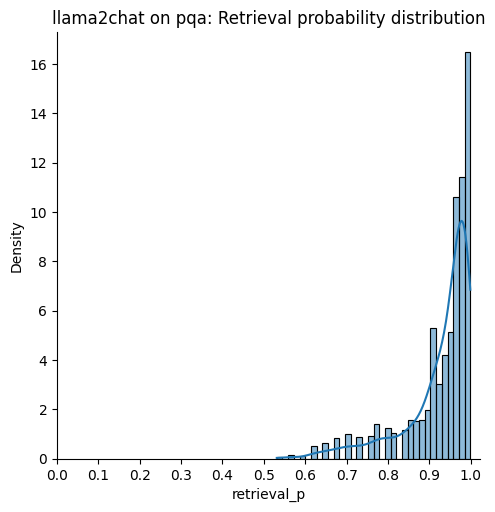

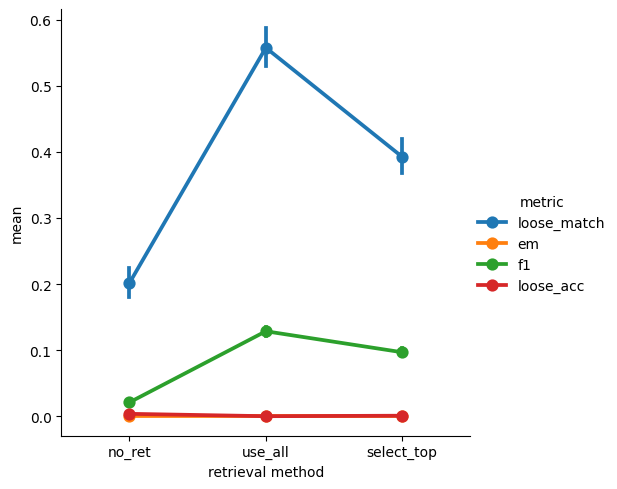

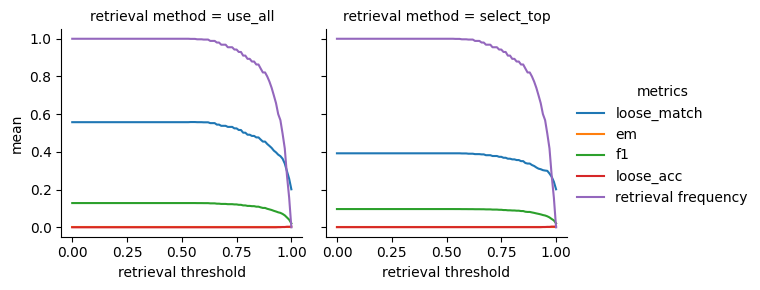

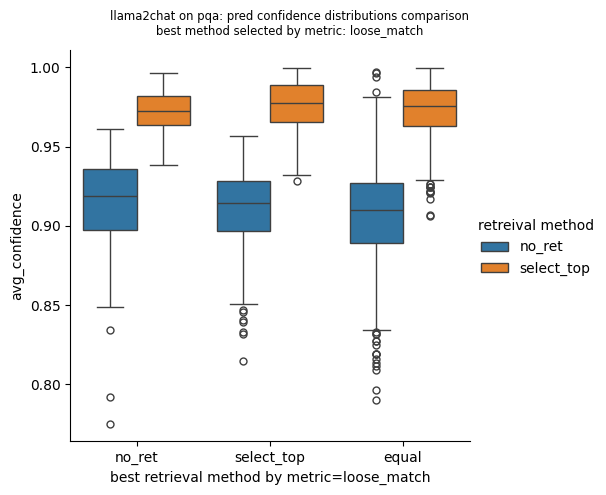

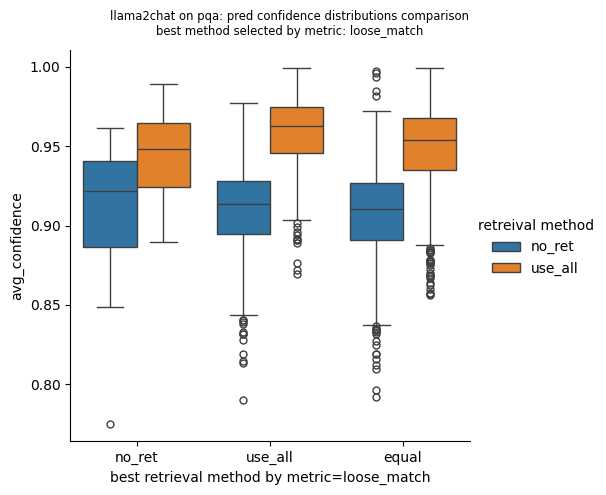

In [18]:
path = 'eval_res\llama2chat-pqa-fullspan.json'
analyzer = Analyzer(path, {"retrieval_p": ret_p_file['retrieval_p']}, threshold=0.2, recompute_fn=recompute_score_inv_perplexity)
if 'pqa' in path or 'tqa' in path:
    metric="loose_match"
else:
    metric='loose_acc'
analyzer.draw_plots(metrics = ["loose_match"], indicators=["avg_confidence"])

In [ ]:

path = 'eval_res\llama7b-fullspan-health--use_default_prompt-token50_1.json'
pqa_analyzer = Analyzer(path, ret_p='health_prompt.json')

dict_keys(['prompts', 'no_retrieval', 'no_retrieval_ids', 'no_retrieval_log_probs', 'all_doc_retrieval', 'all_doc_retrieval_ids', 'all_doc_retrieval_log_probs', 'best_one', 'retrieval', 'retrieval_token_ids', 'retrieval_log_probs', 'retrieval_res', 'question_id', 'gold'])
dict_keys(['retrieval_0', 'retrieval_1', 'retrieval_2', 'retrieval_3', 'retrieval_4'])
====== no_ret ======
Total number of samples: 987

loose_match: 0.171225937183384

em: 0.09321175278622088

f1: 0.1378637218065879

loose_acc: 0.6859169199594731

====== ret_all ======
Threshold: 0.2
Total number of samples: 987
Number of samples with retrieval probability > 0.2: 910
Number of samples with retrieval probability <= 0.2: 77
Retrieval frequency: 0.9219858156028369

loose_match_all_ret: 0.2502532928064843
loose_match_adp_ret: 0.232016210739615

em_all_ret: 0.0
em_adp_ret: 0.002026342451874367

f1_all_ret: 0.03934036004513047
f1_adp_ret: 0.040867904845176

loose_acc_all_ret: 0.49848024316109424
loose_acc_adp_ret: 0.49240

In [ ]:
path = 'eval_res\selfrag-tqa_fullspan.json'
pqa_analyzer = Analyzer(path)
pqa_analyzer.draw_plots()

{'top_doc_retrieval_avg_confidence': [0.9230519460696193, 0.8902223733420003, 0.9091126170110542, 0.8982726317712728, 0.8633194867106028, 0.8486203661727805, 0.9311180722489758, 0.7659749442108992, 0.8962807926668948, 0.9171618528636538, 0.947004265241885, 0.9235727837205464, 0.9400036261457103, 0.8580245676245389, 0.922547220018075, 0.6973518952296666, 0.8586071555148924, 0.843981627713274, 0.906307618716579, 0.9304198005372489, 0.9356085549637773, 0.906444562082109, 0.9046002573888096, 0.8935571821593852, 0.9475646318875672, 0.9124865410317647, 0.9370163038554024, 0.942854009052361, 0.9280852221261261, 0.7833297375803944, 0.8991050874448564, 0.9458035223652197, 0.8944286136652472, 0.9374205477653281, 0.9715918263989475, 0.8392139167017992, 0.8809576878783558, 0.7736613557869528, 0.9320843330704027, 0.8919645764273693, 0.8296614902846533, 0.8637018264416748, 0.799936897273124, 0.7637150104399911, 0.8910049668968557, 0.9404994308416544, 0.7985650096845281, 0.9222363222559344, 0.9409870

In [ ]:
path = 'eval_res\selfrag-fullspan-arc.json'
pqa_analyzer = Analyzer(path)
# pqa_analyzer.draw_plots()



{'top_doc_retrieval_avg_confidence': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

c:\Users\22674\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\22674\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


c:\Users\22674\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\22674\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


=== no_ret ===
Total number of samples: 987
loose_match: 0.7011144883485309
em: 0.7011144883485309
f1: 0.7011144883485309
loose_acc: 0.7011144883485309
=== ret_all ===
Threshold: 0.2
Total number of samples: 987
Number of samples with retrieval probability > 0.2: 987
Number of samples with retrieval probability <= 0.2: 0
Retrieval frequency: 1.0
loose_match: 0.5764944275582573
em: 0.5734549138804458
f1: 0.5743667679837893
loose_acc: 0.5734549138804458
=== ret_top ===
Threshold: 0.2
Total number of samples: 987
Number of samples with retrieval probability > 0.2: 987
Number of samples with retrieval probability <= 0.2: 0
Retrieval frequency: 1.0
loose_match: 0.7244174265450861
em: 0.7244174265450861
f1: 0.7244174265450861
loose_acc: 0.7244174265450861


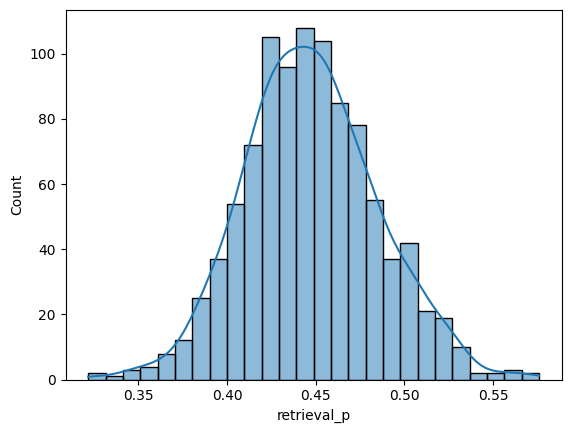

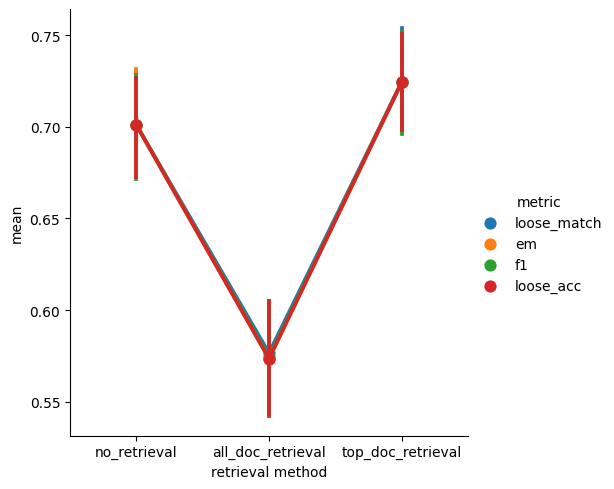

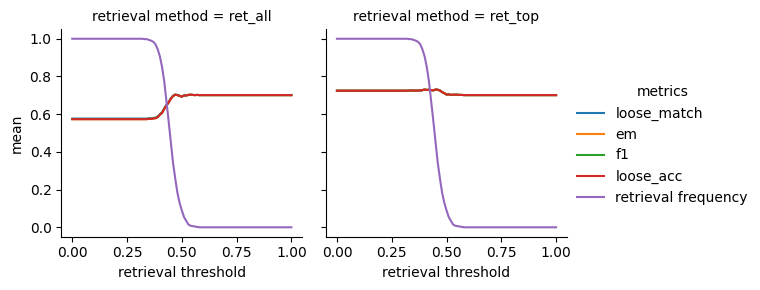

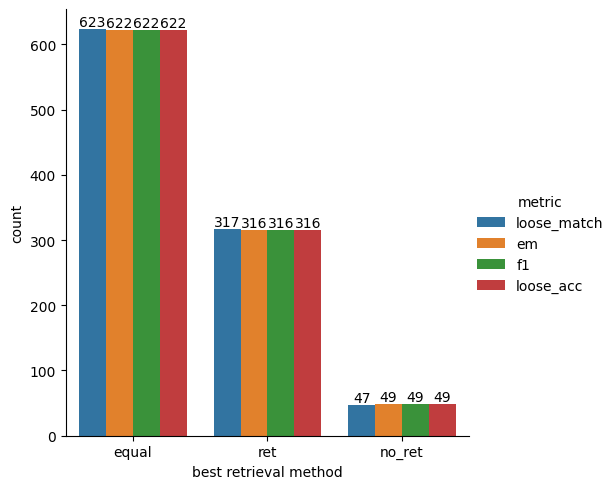

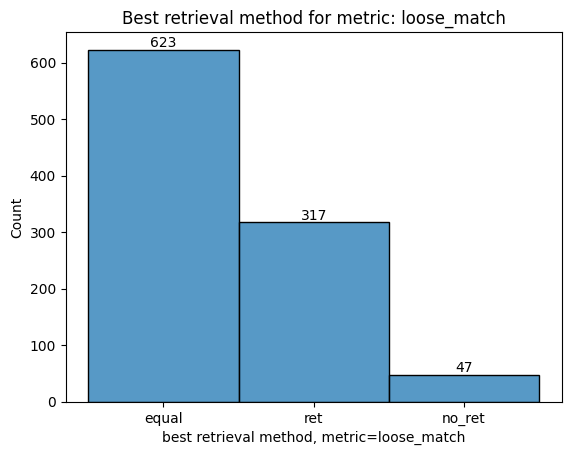

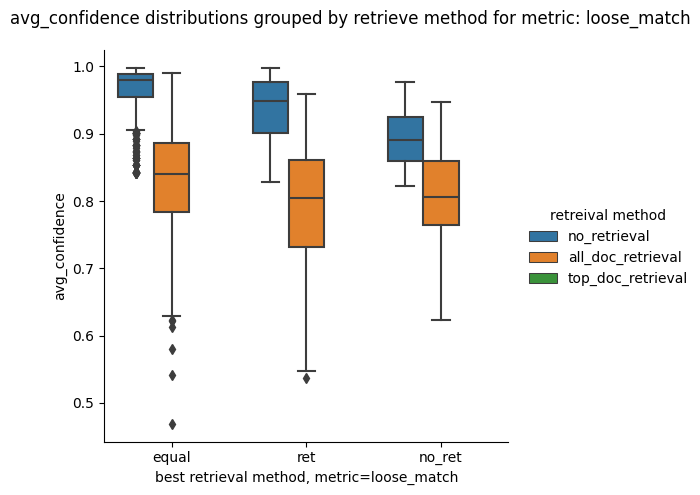

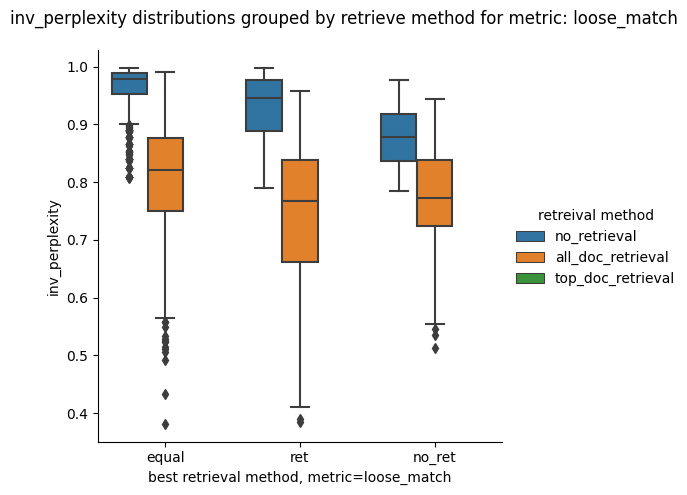

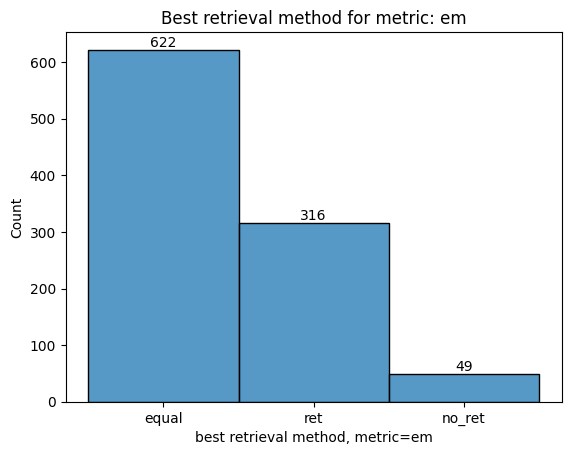

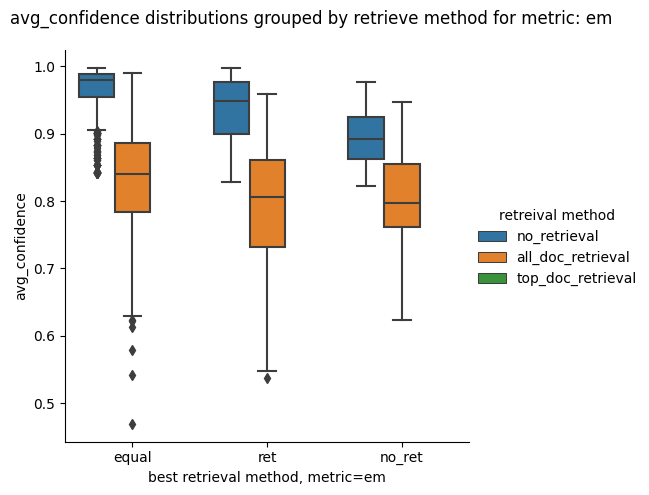

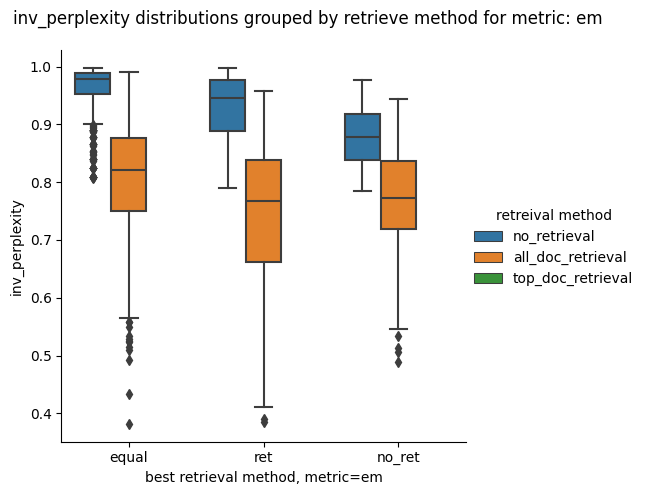

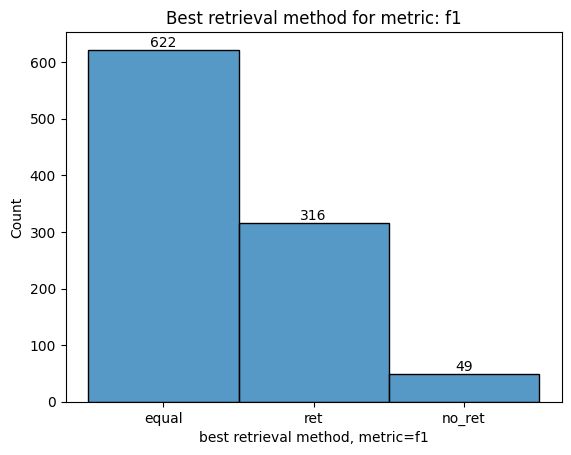

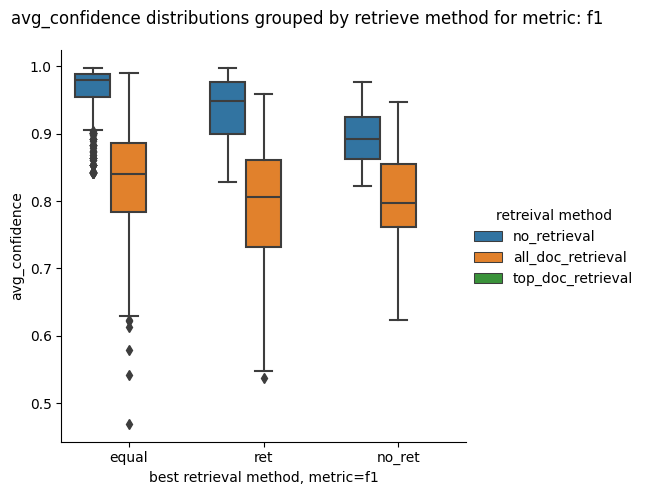

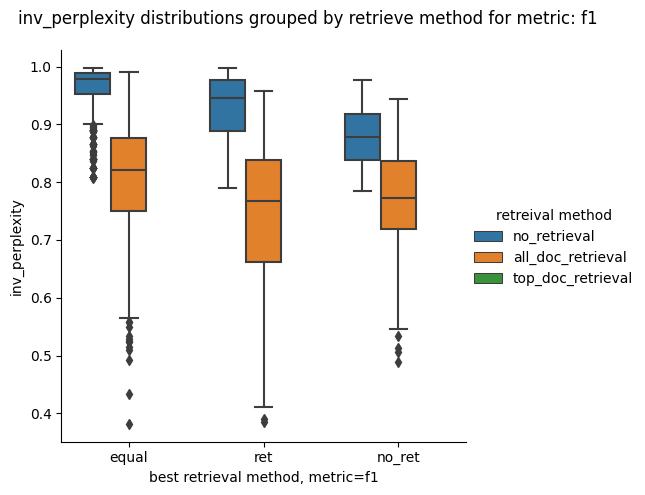

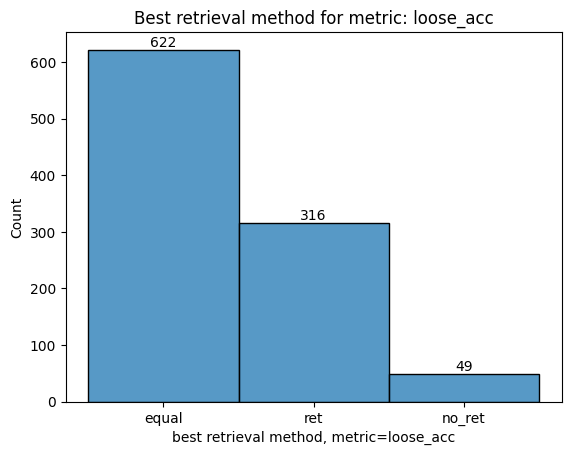

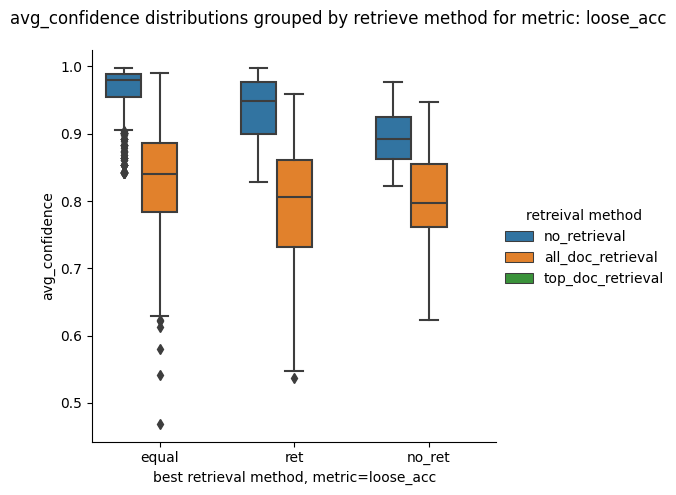

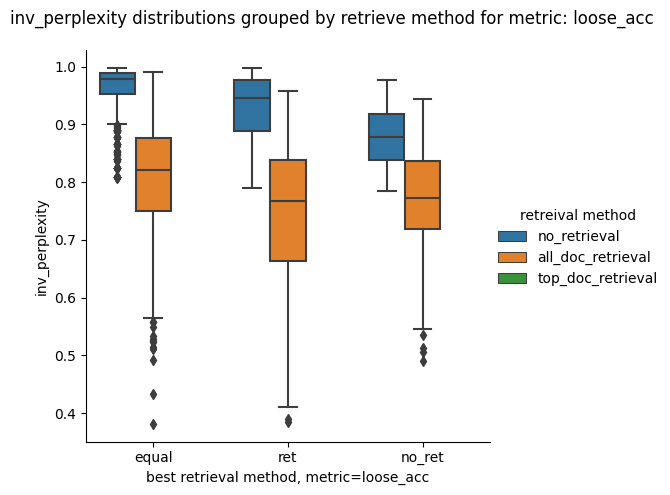

In [ ]:

path = 'eval_res\selfrag-fullspan-health.json'
pqa_analyzer = Analyzer(path)
pqa_analyzer.draw_plots()

=== no_ret ===
Total number of samples: 987
loose_match: 0.0
em: 0.7375886524822695
f1: 0.7381967363407372
loose_acc: 0.7378354218866676
=== ret_all ===
Threshold: 0.2
Total number of samples: 987
Number of samples with retrieval probability > 0.2: 910
Number of samples with retrieval probability <= 0.2: 77
Retrieval frequency: 0.9219858156028369
loose_match_all_ret: 0.0
loose_match_adp_ret: 0.0
em_all_ret: 0.6312056737588653
em_adp_ret: 0.6210739614994935
f1_all_ret: 0.6312836100070143
f1_adp_ret: 0.6215080827309322
loose_acc_all_ret: 0.6312371387037702
loose_acc_adp_ret: 0.6212472127655315
=== ret_top ===
Threshold: 0.2
Total number of samples: 987
Number of samples with retrieval probability > 0.2: 910
Number of samples with retrieval probability <= 0.2: 77
Retrieval frequency: 0.9219858156028369
loose_match_all_ret: 0.0
loose_match_adp_ret: 0.0
em_all_ret: 0.6058763931104356
em_adp_ret: 0.5977710233029382
f1_all_ret: 0.606968872486368
f1_adp_ret: 0.5990447866798588
loose_acc_all_re

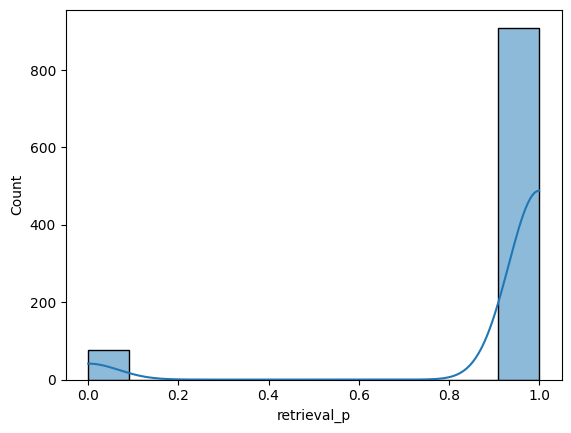

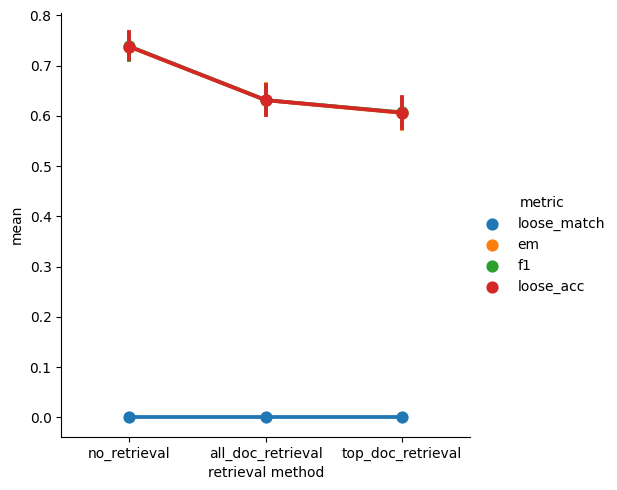

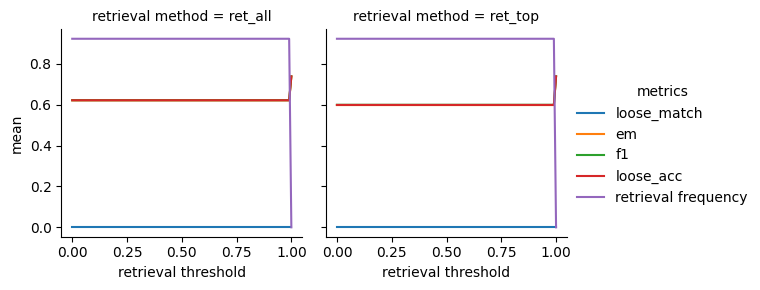

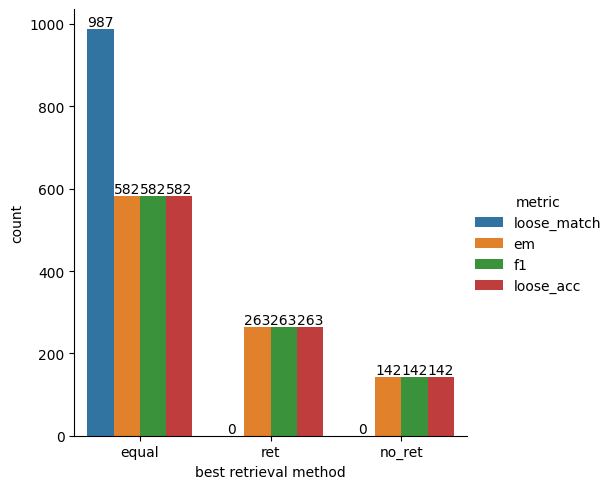

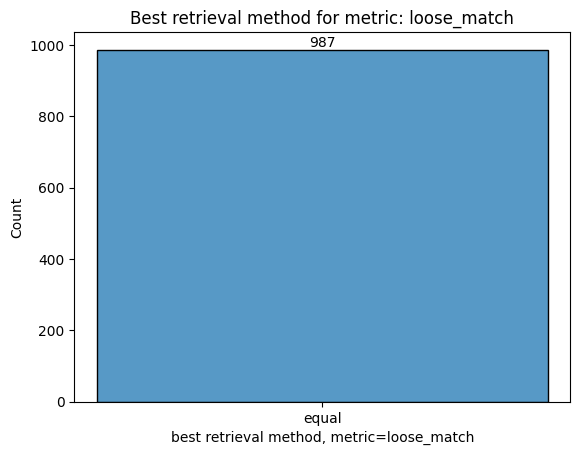

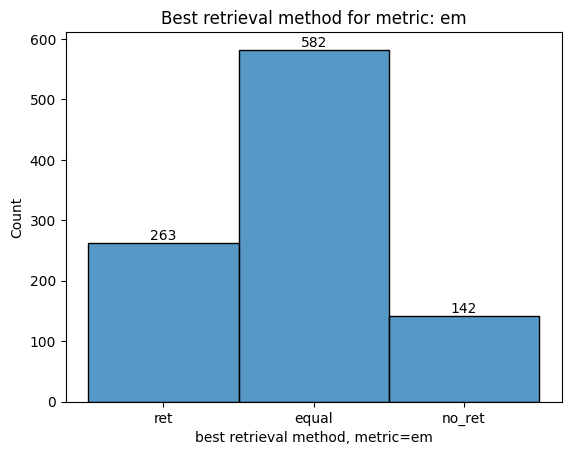

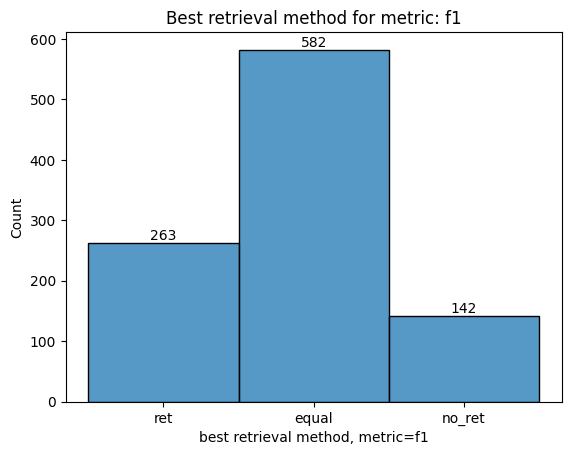

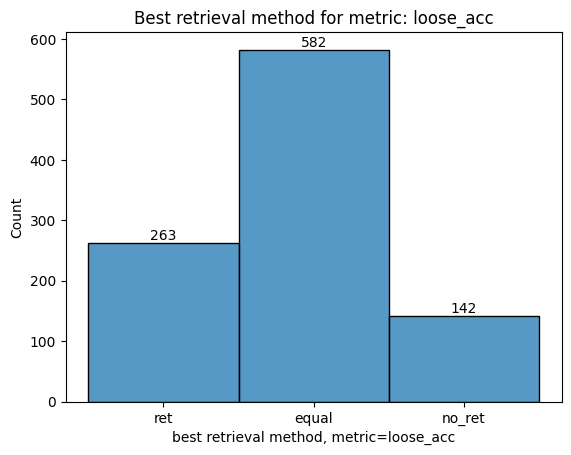

In [ ]:
path = r'eval_res\health_minqi.json'
pqa_analyzer = Analyzer(path)
pqa_analyzer.draw_plots()